<a href="https://colab.research.google.com/github/Adrok24/classification-of-plant-diseases/blob/main/3_plants_disease_labels_resNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Nov 22 14:49:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
from zipfile import ZipFile 
import os

In [4]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import zipfile
folder = 'drive/My Drive/Plant_leaf_diseases_dataset_without_augmentation.zip'

In [6]:
plants_files_folder = "Plant_leave_diseases_dataset_without_augmentation"
with zipfile.ZipFile(folder,"r") as zip_ref:
    zip_ref.extractall("Plants")

In [7]:
base_dir = './Plants'

train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)

validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir, exist_ok=True)

test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

In [8]:
plants_categories = os.listdir('/'.join((base_dir,plants_files_folder)))

# Creamos los directorios para las 39 clases presentes en el dataset
for directory in (train_dir, validation_dir, test_dir):
    for folder_name in plants_categories:
        name_split = folder_name.split('___') 
        plant_name = name_split[0]
        path_dir = ""
        if (len(name_split) > 1):
            plant_health = name_split[1]
            path_dir = os.path.join(directory, plant_health, plant_name)
        else:
            path_dir = os.path.join(directory, plant_name)
        os.makedirs(path_dir, exist_ok=True)

In [9]:
import shutil

for plant_category in plants_categories:
    plants_pictures = os.listdir('/'.join((base_dir,plants_files_folder, plant_category)))


    name_split = plant_category.split('___') 
    plant_name = name_split[0]
    path_dir = ""
    if (len(name_split) > 1):
        plant_health = name_split[1]
        path_dir = os.path.join( plant_health, plant_name)
    else:
        path_dir = os.path.join(plant_name)
    #print(path_dir)
    
    #Dividimos train 80%, validation 10% y test 10%. 
    train_ds = plants_pictures[:int(len(plants_pictures)*0.8)]
    val_ds = plants_pictures[int(len(plants_pictures)*0.8):int(len(plants_pictures)*0.9)]
    test_ds = plants_pictures[int(len(plants_pictures)*0.9):len(plants_pictures)]

    #Copio los porcentajes de cada clase en su correspondiente carpeta
    fnames = [i for i in train_ds]
    for fname in fnames:
        # try:
            src = os.path.join(base_dir,plants_files_folder, plant_category, fname)
            dst = os.path.join(base_dir,'train',path_dir, fname)
            shutil.copyfile(src, dst)
        # except OSError:
            pass

    
    fnames = [i for i in val_ds]
    for fname in fnames:
        # try:
            src = os.path.join(base_dir,plants_files_folder, plant_category, fname)
            dst = os.path.join(base_dir,'validation',path_dir, fname)
            shutil.copyfile(src, dst)      
        # except:
            pass


    fnames = [i for i in test_ds]
    for fname in fnames:
        # try:
            src = os.path.join(base_dir,plants_files_folder, plant_category, fname)
            dst = os.path.join(base_dir,'test',path_dir, fname)
            shutil.copyfile(src, dst)
                
        # except OSError:
            pass
        

In [10]:
#creamos DataFrames de train test y val
import pandas as pd
dict_train = {}
count_files = 0

for root, dirs, files in os.walk(train_dir, topdown=False):
    for name_file in files:
        dict_train[count_files] = {"file": os.path.join(root, name_file), "path": root, "health": root.split('/')[3], "type": root.split('/')[4] if len(root.split('/')) > 4 else root.split('/')[3]}
        count_files = count_files + 1

df_train = pd.DataFrame.from_dict(dict_train, "index")
display(df_train.shape)

dict_test = {}
count_files = 0

for root, dirs, files in os.walk(test_dir, topdown=False):
    for name_file in files:
        dict_test[count_files] = {"file": os.path.join(root, name_file), "path": root, "health": root.split('/')[3], "type": root.split('/')[4] if len(root.split('/')) > 4 else root.split('/')[3]}
        count_files = count_files + 1

df_test = pd.DataFrame.from_dict(dict_test, "index")
display(df_test.shape)

dict_validation = {}
count_files = 0

for root, dirs, files in os.walk(validation_dir, topdown=False):
    for name_file in files:
        dict_validation[count_files] = {"file": os.path.join(root, name_file), "path": root, "health": root.split('/')[3], "type": root.split('/')[4] if len(root.split('/')) > 4 else root.split('/')[3]}
        count_files = count_files + 1

df_validation = pd.DataFrame.from_dict(dict_validation, "index")
display(df_validation.shape)

(44343, 4)

(5563, 4)

(5542, 4)

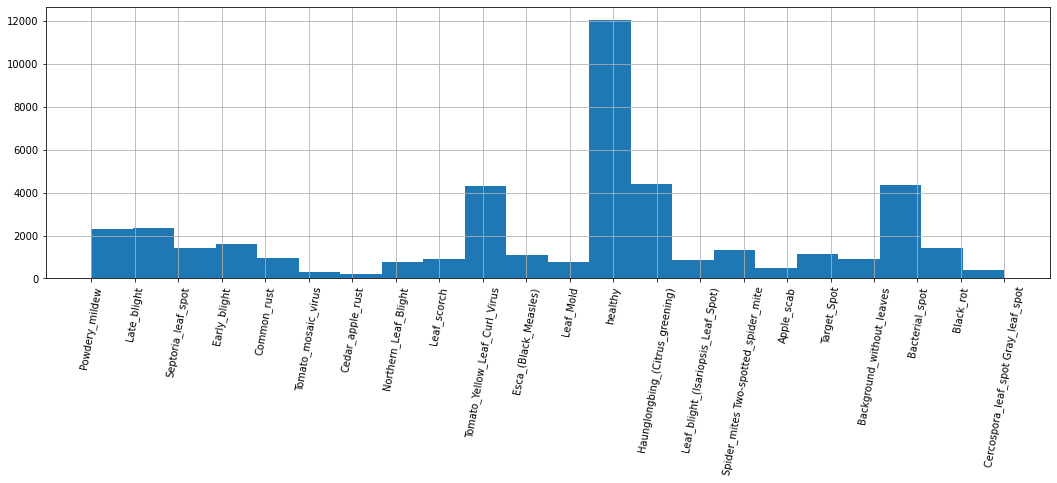

In [11]:
df_train.health.hist(figsize=(18,5), xrot=80, bins=df_train.health.value_counts().shape[0])

In [12]:
df_train.health.value_counts()

healthy                                 12062
Haunglongbing_(Citrus_greening)          4405
Bacterial_spot                           4335
Tomato_Yellow_Leaf_Curl_Virus            4285
Late_blight                              2327
Powdery_mildew                           2309
Early_blight                             1600
Black_rot                                1440
Septoria_leaf_spot                       1416
Spider_mites Two-spotted_spider_mite     1340
Target_Spot                              1123
Esca_(Black_Measles)                     1106
Common_rust                               953
Background_without_leaves                 914
Leaf_scorch                               887
Leaf_blight_(Isariopsis_Leaf_Spot)        860
Northern_Leaf_Blight                      788
Leaf_Mold                                 761
Apple_scab                                504
Cercospora_leaf_spot Gray_leaf_spot       410
Tomato_mosaic_virus                       298
Cedar_apple_rust                  

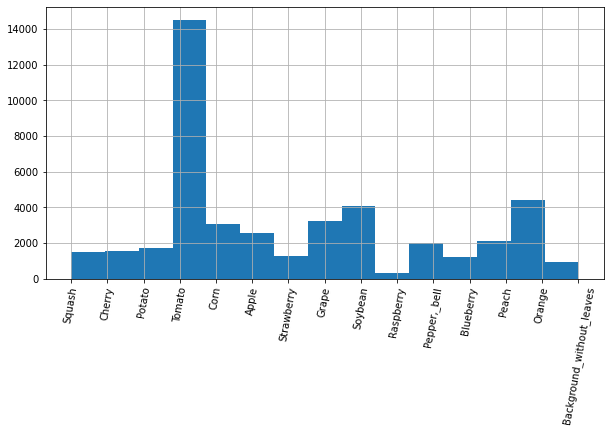

In [13]:
df_train.type.hist(figsize=(10,5), xrot=80, bins=df_train.type.value_counts().shape[0])

In [14]:
df_train.type.value_counts()

Tomato                       14523
Orange                        4405
Soybean                       4072
Grape                         3248
Corn                          3080
Apple                         2536
Peach                         2125
Pepper,_bell                  1979
Potato                        1721
Cherry                        1524
Squash                        1468
Strawberry                    1251
Blueberry                     1201
Background_without_leaves      914
Raspberry                      296
Name: type, dtype: int64

./Plants/train/healthy/Soybean/image (2183).JPG


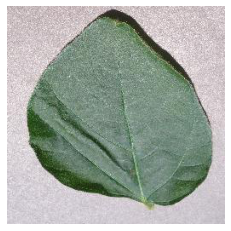

./Plants/train/Tomato_Yellow_Leaf_Curl_Virus/Tomato/image (2411).JPG


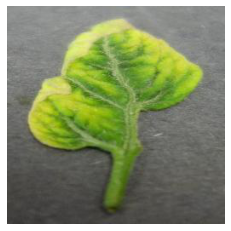

./Plants/train/Late_blight/Tomato/image (860).jpg


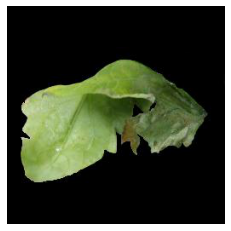

./Plants/train/Leaf_blight_(Isariopsis_Leaf_Spot)/Grape/image (840).JPG


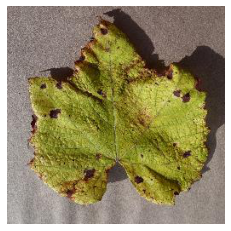

./Plants/train/Bacterial_spot/Peach/image (2288).JPG


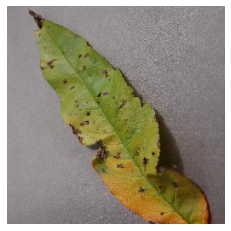

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image

for index in np.random.choice(df_train.shape[0], 5):
  plant = df_train.iloc[index].file
  print(plant)
  plt.imshow(image.load_img(plant))
  plt.axis('off')
  plt.show()  

In [11]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
      rotation_range=25,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.2,
      zoom_range=0.25,
      horizontal_flip=True,
      fill_mode='nearest')

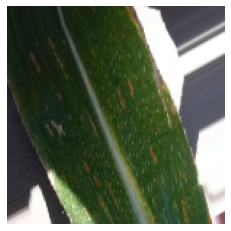

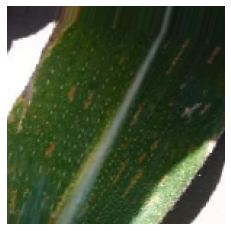

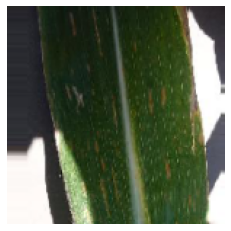

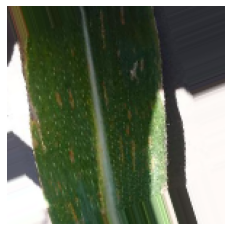

In [17]:
# Elegimos una imagen para "aumentar"
img_path = df_train.iloc[-2].file

# La leemos y la reescalamos
img = image.load_img(img_path, target_size=(150, 150))

# La convertimos a un Numpy de forma (150, 150, 3)
x = image.img_to_array(img)

# La reescalamos a (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# El comando .flow() genera batches de imágenes transformadas aleatoriamente
# Usamos un `break` para cortar el loop en algún momento
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    plt.axis('off')
    i += 1
    if i % 4 == 0:
        break

In [12]:
from keras.preprocessing.image import ImageDataGenerator
data_dir = ""
# Reescalamos todas las imágenes en un factor de 1./255
train_datagen = ImageDataGenerator(
      rotation_range=25,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.2,
      zoom_range=0.25,
      horizontal_flip=True,
      fill_mode='nearest',
      rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    df_train, # Referimos el df de train
    directory=data_dir, # El directorio donde se encuentran las imágenes
    x_col='file', # La columna con los path de los archivos
    y_col=['health', 'type'], # La variable con las labels
    target_size=(150, 150),
    classes=None, # Las clases se obtienen a partir de y_col
    class_mode='multi_output', # Se trata de un problema multi-output, multi-label
    batch_size=32
   )

val_generator = test_datagen.flow_from_dataframe(
    df_validation, # Referimos el df de validación
    directory=data_dir, # El directorio donde se encuentran las imágenes
    x_col='file', # La columna con los path de los archivos
    y_col=['health', 'type'], # La variable con las labels
    target_size=(150, 150),
    classes=None, # Las clases se obtienen a partir de y_col
    class_mode='multi_output', # Se trata de un problema multi-output, multi-label
    batch_size=32,
    shuffle=False
   )

Found 44343 validated image filenames.
Found 5542 validated image filenames.


In [19]:
df_train

,file,path,health,type
0,./Plants/train/Powdery_mildew/Squash/image (10...,./Plants/train/Powdery_mildew/Squash,Powdery_mildew,Squash
1,./Plants/train/Powdery_mildew/Squash/image (15...,./Plants/train/Powdery_mildew/Squash,Powdery_mildew,Squash
2,./Plants/train/Powdery_mildew/Squash/image (86...,./Plants/train/Powdery_mildew/Squash,Powdery_mildew,Squash
3,./Plants/train/Powdery_mildew/Squash/image (52...,./Plants/train/Powdery_mildew/Squash,Powdery_mildew,Squash
4,./Plants/train/Powdery_mildew/Squash/image (13...,./Plants/train/Powdery_mildew/Squash,Powdery_mildew,Squash
...,...,...,...,...
44338,./Plants/train/Cercospora_leaf_spot Gray_leaf_...,./Plants/train/Cercospora_leaf_spot Gray_leaf_...,Cercospora_leaf_spot Gray_leaf_spot,Corn
44339,./Plants/train/Cercospora_leaf_spot Gray_leaf_...,./Plants/train/Cercospora_leaf_spot Gray_leaf_...,Cercospora_leaf_spot Gray_leaf_spot,Corn
44340,./Plants/train/Cercospora_leaf_spot Gray_leaf_...,./Plants/train/Cercospora_leaf_spot Gray_leaf_...,Cercospora_leaf_spot Gray_leaf_spot,Corn
44341,./Plants/train/Cercospora_leaf_spot Gray_leaf_...,./Plants/train/Cercospora_leaf_spot Gray_leaf_...,Cercospora_leaf_spot Gray_leaf_spot,Corn


In [20]:
#Testeamos nuestro generador
x, y = train_generator.next()
print('x shape: ',x.shape)
print('y1 shape: ',y[0].shape)
print('y2 shape: ',y[1].shape)
print('y1: ',y[0])
print('y2: ',y[1])

x shape:  (32, 150, 150, 3)
y1 shape:  (32,)
y2 shape:  (32,)
y1:  ['Bacterial_spot' 'Haunglongbing_(Citrus_greening)'
 'Background_without_leaves' 'Tomato_Yellow_Leaf_Curl_Virus' 'healthy'
 'Tomato_mosaic_virus' 'healthy' 'healthy' 'Black_rot' 'healthy' 'healthy'
 'Apple_scab' 'Tomato_Yellow_Leaf_Curl_Virus' 'healthy' 'healthy'
 'Late_blight' 'Early_blight' 'healthy' 'Tomato_Yellow_Leaf_Curl_Virus'
 'Haunglongbing_(Citrus_greening)' 'healthy' 'healthy' 'healthy'
 'Bacterial_spot' 'Haunglongbing_(Citrus_greening)'
 'Spider_mites Two-spotted_spider_mite' 'Leaf_scorch'
 'Haunglongbing_(Citrus_greening)' 'Late_blight'
 'Haunglongbing_(Citrus_greening)' 'Esca_(Black_Measles)' 'healthy']
y2:  ['Tomato' 'Orange' 'Background_without_leaves' 'Tomato' 'Soybean' 'Tomato'
 'Apple' 'Strawberry' 'Apple' 'Peach' 'Grape' 'Apple' 'Tomato' 'Apple'
 'Soybean' 'Tomato' 'Potato' 'Soybean' 'Tomato' 'Orange' 'Corn' 'Grape'
 'Apple' 'Tomato' 'Orange' 'Tomato' 'Strawberry' 'Orange' 'Tomato'
 'Orange' 'Grape' 

In [41]:
from sklearn.preprocessing import OneHotEncoder

In [42]:
#Creamos un encoder para devolver valores de outputs en nuestro generador personalizado
heal_encoder = OneHotEncoder()
heal_encoder.fit(df_train['health'].to_numpy().reshape(-1, 1))
type_encoder = OneHotEncoder()
type_encoder.fit(df_train['type'].to_numpy().reshape(-1, 1))

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

In [23]:
def custom_generator(generator):
  while True:
    x, y = generator.next()
    y1_encoded = heal_encoder.transform(y[0].reshape(-1, 1)).toarray()
    y2_encoded = type_encoder.transform(y[1].reshape(-1, 1)).toarray()

    yield (x, [y1_encoded, y2_encoded])

Ahora, veamos cómo definir la misma red con la clase `Model` y la sintaxis de la API funcional:

In [24]:
# Importamos las clases Model e Input del módulo de modelos y capas, respectivamente
%load_ext tensorboard
import tensorflow as tf
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, ZeroPadding2D, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Add, Dense
from tensorflow.keras.initializers import he_normal
import datetime

In [25]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [26]:
def identity_block(input_tensor, kernel_size, filters, stage, block, seed=None):
    """
    El bloque identidad es aquel que no incluye una capa convolucional en el shortcut.
    Las dimensiones de entrada coinciden con las de salida.
    """
    # Definimos el nombre base
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Hacemos unpacking de los filtros
    filters1, filters2, filters3 = filters
    
    # Guardamos el valor del input
    x_shortcut = input_tensor
    
    ##### MAIN PATH #####
    # Primer componente del main path
    x = Conv2D(filters=filters1, kernel_size=(1, 1),
               kernel_initializer=he_normal(seed=seed),
               name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=3, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)
    
    # Segundo componente del main path
    x = Conv2D(filters=filters2, kernel_size=kernel_size,
               padding='same', kernel_initializer=he_normal(seed=seed),
               name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=3, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    # Tercer componente del main path
    x = Conv2D(filters=filters3, kernel_size=(1, 1),
               kernel_initializer=he_normal(seed=seed),
               name = conv_name_base + '2c')(x)
    x = BatchNormalization(axis=3, name=bn_name_base + '2c')(x)

    ##### SHORTCUT PATH #####
    # Último paso: sumamos el shortcut al main path y lo pasamos por una ReLU
    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)
    
    return x

In [31]:
health_utput_units =  df_train.health.value_counts().shape[0]
type_utput_units =  df_train.type.value_counts().shape[0]

# Definimos una variable que será una instancia de la clase Input
# donde especificamos las dimensiones de los datos de entrada
input_layer = Input(shape=(150, 150, 3))
# Definimos una variable distinta para cada capa del modelo

resnet101V2_pretrained_2 = ResNet101V2(
    include_top=False,
    pooling=None,
    input_shape=((150, 150, 3)),
)

resnet101V2_pretrained_2.trainable = False

x = resnet101V2_pretrained_2(input_layer)

########## HEALTH LAYERS
x_health = identity_block(x, 3, [512, 512, 2048], stage=5, block='last_health')
x_health = GlobalAveragePooling2D(name='avg_pool_health')(x_health)
x_health = Dense(512, activation='relu')(x_health)
health_output_layer = Dense(health_utput_units, activation='softmax', name='health_output')(x_health)

##########
########## TYPE LAYERS
x_type = identity_block(x, 3, [512, 512, 2048], stage=6, block='last_health')
x_type = GlobalAveragePooling2D(name='avg_pool_type')(x_type)
x_type = Dense(512, activation='relu')(x_type)
x_type_output_layer = Dense(type_utput_units, activation='softmax', name='type_output')(x_type)
##########

# Creamos la instancia del modelo multi-input
# Al haber múltiples entradas, definimos una lista de inputs
model = Model(input_layer, [health_output_layer,x_type_output_layer])

In [32]:
# Vemos que el summary del modelo es exactamente el mismo
# salvo que ahora se especifica la InputLayer, antes omitida
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
resnet101v2 (Functional)        (None, 5, 5, 2048)   42626560    input_5[0][0]                    
__________________________________________________________________________________________________
res5last_health_branch2a (Conv2 (None, 5, 5, 512)    1049088     resnet101v2[0][0]                
__________________________________________________________________________________________________
res6last_health_branch2a (Conv2 (None, 5, 5, 512)    1049088     resnet101v2[0][0]                
_______________________________________________________________________________________

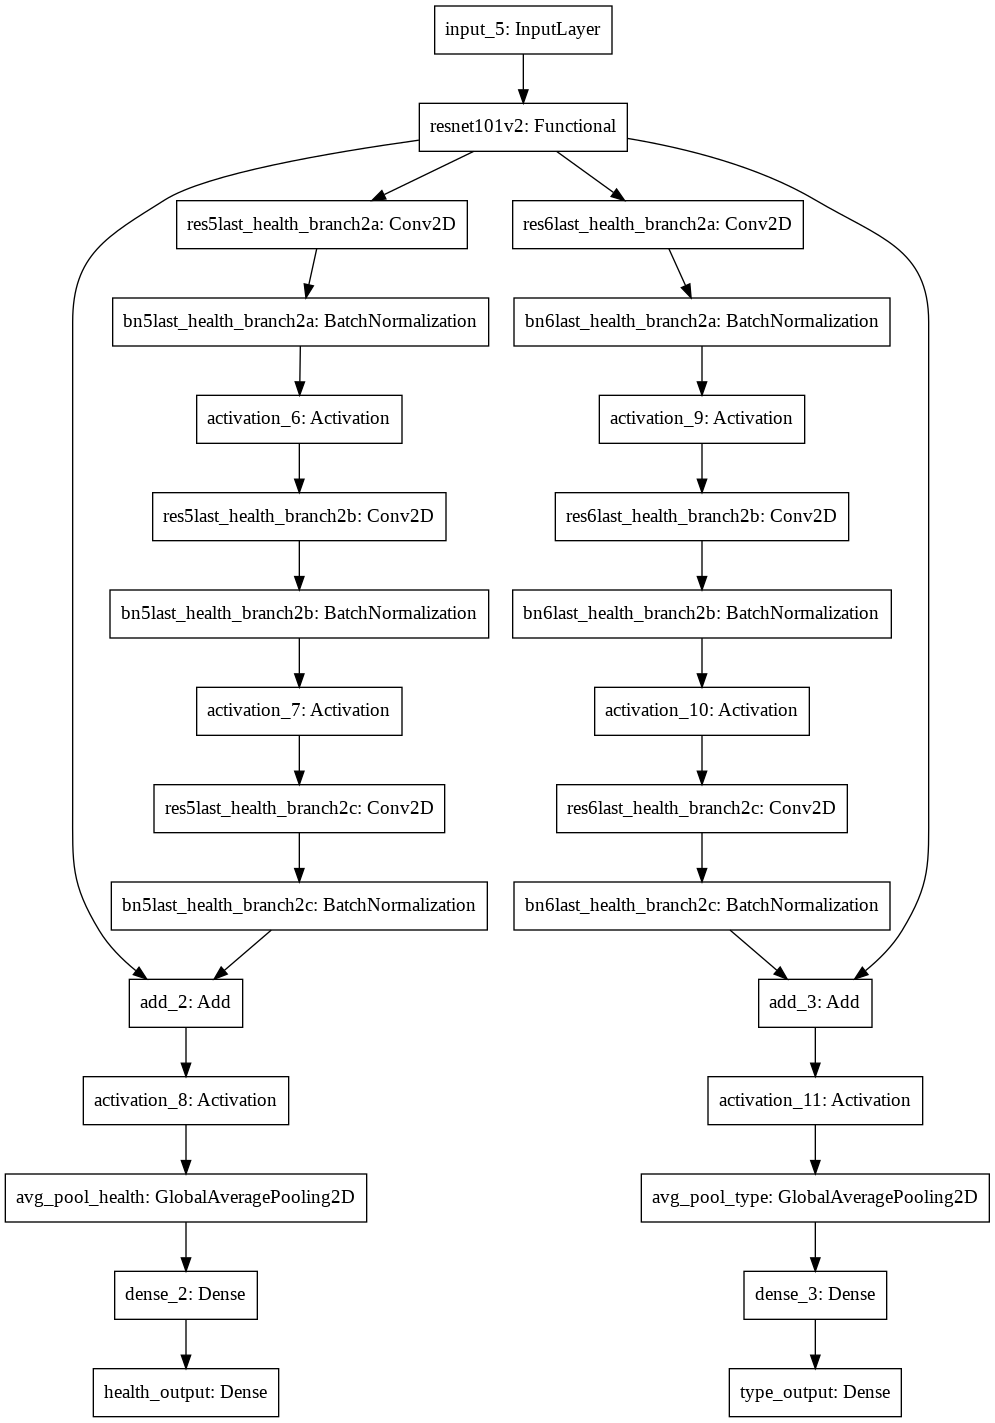

In [33]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [34]:
from keras import optimizers

model.compile(loss={'health_output' : 'categorical_crossentropy', 'type_output': 'categorical_crossentropy'}, 
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics={'health_output' : 'accuracy', 'type_output': 'accuracy'})

In [35]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Instanciamos nuestro objeto early_stopping
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, restore_best_weights=True, verbose=1)

checkpoint = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/Desafio II/labels_w/weights_resnet.{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss', verbose=0,
                             save_best_only=True, save_weights_only=False, mode='auto')

# Definimos una lista de callbacks
callbacks_list = [checkpoint]

In [36]:
spe = int(df_train.shape[0]/ 32) + 1
history = model.fit_generator(custom_generator(train_generator),
                              steps_per_epoch=spe,
                              epochs=40,
                              validation_data=custom_generator(val_generator),
                              validation_steps=100,
                              callbacks=callbacks_list)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/40
1386/1386 [==============================] - 299s 216ms/step - loss: 0.9039 - health_output_loss: 0.5965 - type_output_loss: 0.3074 - health_output_accuracy: 0.8104 - type_output_accuracy: 0.9022 - val_loss: 0.4009 - val_health_output_loss: 0.2770 - val_type_output_loss: 0.1239 - val_health_output_accuracy: 0.9044 - val_type_output_accuracy: 0.9591
Epoch 2/40
1386/1386 [==============================] - 294s 212ms/step - loss: 0.5034 - health_output_loss: 0.3460 - type_output_loss: 0.1573 - health_output_accuracy: 0.8845 - type_output_accuracy: 0.9499 - val_loss: 0.4376 - val_health_output_loss: 0.3225 - val_type_output_loss: 0.1151 - val_health_output_accuracy: 0.8979 - val_type_output_accuracy: 0.9635
Epoch 3/40
1386/1386 [==============================] - 293s 212ms/step - loss: 0.4072 - health_output_loss: 0.2832 - type_output_loss: 0.1239 - health_output_accuracy: 0.9051 - type_output_accuracy: 

In [37]:
model.save('drive/My Drive/Colab Notebooks/Desafio II/plans_disease_labels_resnet.h5')

In [ ]:
# # Classification report
len(tick_labels)
print('\nClassification Report:\n')
print(classification_report(test_generator.classes, y_pred, target_names=tick_labels, digits = 6, labels=range(len(tick_labels))))

NameError: ignored

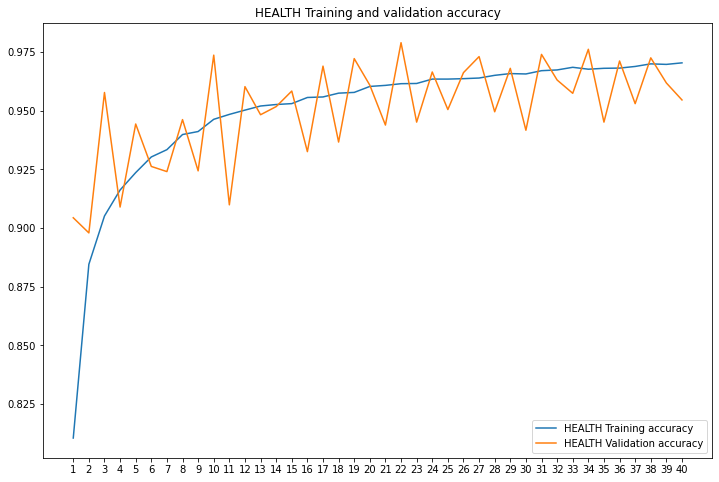

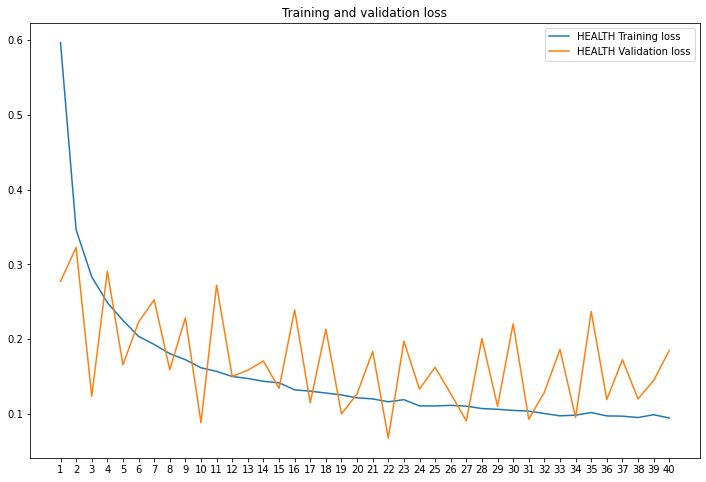

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [38]:
acc = history.history['health_output_accuracy']
val_acc = history.history['val_health_output_accuracy']
loss = history.history['health_output_loss']
val_loss = history.history['val_health_output_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))
plt.plot(epochs, acc, label='HEALTH Training accuracy')
plt.plot(epochs, val_acc, label='HEALTH Validation accuracy')
plt.xticks(ticks=epochs)
plt.title('HEALTH Training and validation accuracy')
plt.legend()

plt.figure(figsize=(12,8))
plt.plot(epochs, loss, label='HEALTH Training loss')
plt.plot(epochs, val_loss, label='HEALTH Validation loss')
plt.xticks(ticks=epochs)
plt.title('Training and validation loss')
plt.legend()
plt.show()
plt

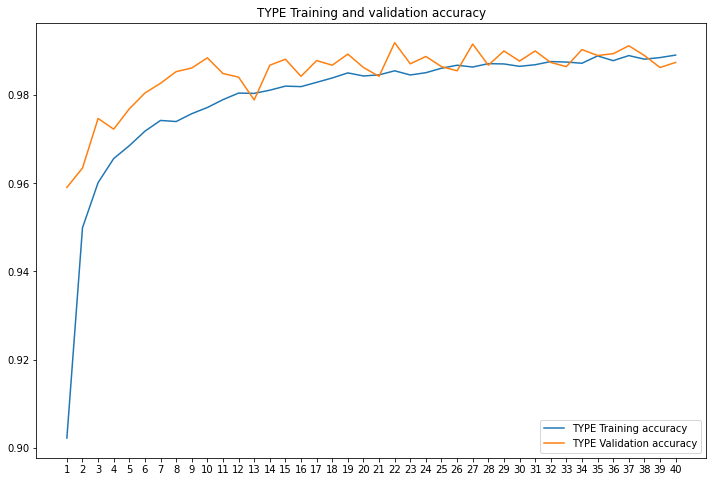

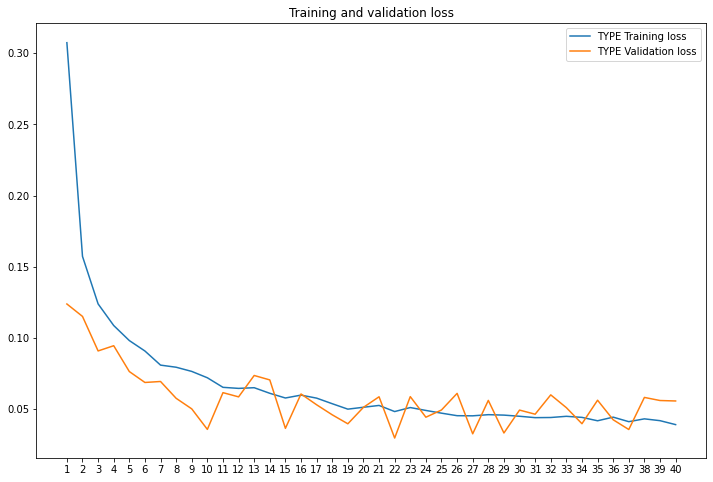

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [39]:
acc = history.history['type_output_accuracy']
val_acc = history.history['val_type_output_accuracy']
loss = history.history['type_output_loss']
val_loss = history.history['val_type_output_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))
plt.plot(epochs, acc, label='TYPE Training accuracy')
plt.plot(epochs, val_acc, label='TYPE Validation accuracy')
plt.xticks(ticks=epochs)
plt.title('TYPE Training and validation accuracy')
plt.legend()

plt.figure(figsize=(12,8))
plt.plot(epochs, loss, label='TYPE Training loss')
plt.plot(epochs, val_loss, label='TYPE Validation loss')
plt.xticks(ticks=epochs)
plt.title('Training and validation loss')
plt.legend()
plt.show()
plt

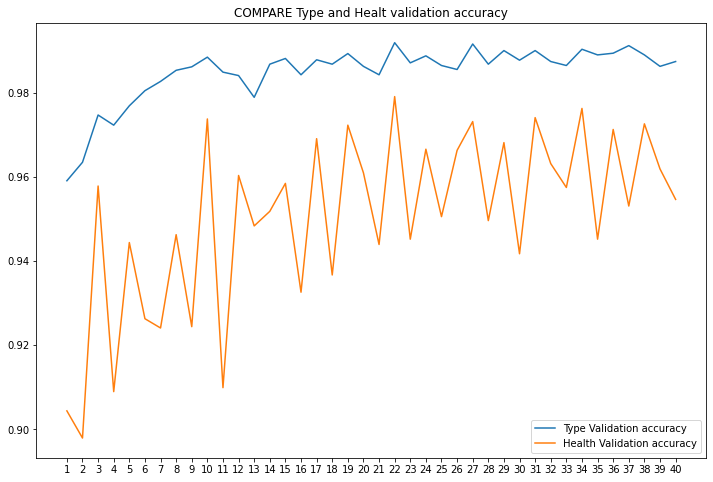

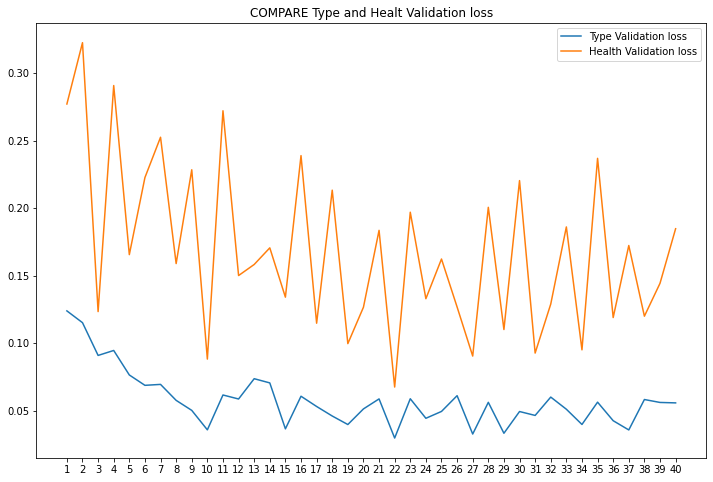

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [40]:
acc = history.history['val_type_output_accuracy']
val_acc = history.history['val_health_output_accuracy']
loss = history.history['val_type_output_loss']
val_loss = history.history['val_health_output_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))
plt.plot(epochs, acc, label='Type Validation accuracy')
plt.plot(epochs, val_acc, label='Health Validation accuracy')
plt.xticks(ticks=epochs)
plt.title('COMPARE Type and Healt validation accuracy')
plt.legend()

plt.figure(figsize=(12,8))
plt.plot(epochs, loss, label='Type Validation loss')
plt.plot(epochs, val_loss, label='Health Validation loss')
plt.xticks(ticks=epochs)
plt.title('COMPARE Type and Healt Validation loss')
plt.legend()
plt.show()
plt

In [41]:
history.history

{'health_output_accuracy': [0.8104097843170166,
  0.8845364451408386,
  0.9051259756088257,
  0.9162212610244751,
  0.9236407279968262,
  0.9303159713745117,
  0.9334280490875244,
  0.9398777484893799,
  0.941163182258606,
  0.9463725686073303,
  0.948469877243042,
  0.9502965807914734,
  0.9520555734634399,
  0.9526870250701904,
  0.9530704021453857,
  0.9556863307952881,
  0.9559118747711182,
  0.9575355648994446,
  0.9578512907028198,
  0.9603996276855469,
  0.9608506560325623,
  0.9615722894668579,
  0.9616624712944031,
  0.9635342955589294,
  0.9635342955589294,
  0.9637146592140198,
  0.9639853239059448,
  0.965135395526886,
  0.9658796191215515,
  0.9657217860221863,
  0.9671199321746826,
  0.9674356579780579,
  0.9685632586479187,
  0.9677513837814331,
  0.9681347608566284,
  0.9682250022888184,
  0.9689240455627441,
  0.9700291156768799,
  0.9698035717010498,
  0.9704575538635254],
 'health_output_loss': [0.596511960029602,
  0.34604182839393616,
  0.2832370102405548,
  0.2486

In [13]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/My Drive/Colab Notebooks/Desafio II/plans_disease_labels_resnet.h5')

In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

test_datagen = ImageDataGenerator(rescale=1./255)

Found 5563 validated image filenames.


In [ ]:
tick_labels = heal_encoder.categories_[0].tolist()
print(len(tick_labels))
health_output_accuracy, health_output_loss, loss, type_output_accuracy, type_output_loss = model.evaluate_generator(custom_generator(test_generator), steps=200)
print('Health Accuracy en test:', np.round(health_output_accuracy, 2))
print('Type Accuracy en test:', np.round(type_output_accuracy, 2))


22
Instructions for updating:
Please use Model.evaluate, which supports generators.
Health Accuracy en test: 1.31
Type Accuracy en test: 0.8


In [46]:
tick_labels_h = heal_encoder.categories_[0].tolist()
tick_labels_h[15]
tick_labels_t = type_encoder.categories_[0].tolist()
tick_labels_t[12]

'Squash'

In [53]:
from IPython.display import clear_output

In [63]:
list_test_pred_health = []
list_test_pred_type= []
preds_true = 0
for index, plant in df_test.iterrows():
  img = image.load_img(plant.file, target_size=(150, 150))

  # La convertimos a un Numpy de forma (150, 150, 3)
  x = image.img_to_array(img)

  # La reescalamos a (1, 150, 150, 3)
  x = x.reshape((1,) + x.shape)

  batch = test_datagen.flow(x, batch_size=1)
  plt.figure(i)

  #imgplot = plt.imshow(image.array_to_img(batch[0][0]))
  health_pred, type_pred = model.predict(batch[0])
  health_pred_lbl = tick_labels_h[np.argmax(health_pred)]
  type_pred_lbl = tick_labels_t[np.argmax(type_pred)]
  list_test_pred_health.append(health_pred_lbl)
  list_test_pred_type.append(type_pred_lbl)
  if plant.type + plant.health == type_pred_lbl + health_pred_lbl:
    preds_true += 1
  
  clear_output(wait=True)
  print(np.round(preds_true / (index + 1), 2))

0.96


<Figure size 432x288 with 0 Axes>

In [66]:
df_test.loc[:,['healt_pred']] = list_test_pred_health
df_test.loc[:,['type_pred']] = list_test_pred_type

In [70]:
df_test.loc[:,['concat_real']] = df_test.apply(lambda x: x.type + '__' + x.health, axis=1)
df_test.loc[:,['concat_pred']] = df_test.apply(lambda x: x.type_pred + '__' + x.healt_pred, axis=1)

In [71]:
df_test

,file,path,health,type,healt_pred,type_pred,concat_real,concat_pred
0,./Plants/test/Powdery_mildew/Squash/image (356...,./Plants/test/Powdery_mildew/Squash,Powdery_mildew,Squash,Powdery_mildew,Squash,Squash__Powdery_mildew,Squash__Powdery_mildew
1,./Plants/test/Powdery_mildew/Squash/image (175...,./Plants/test/Powdery_mildew/Squash,Powdery_mildew,Squash,Powdery_mildew,Squash,Squash__Powdery_mildew,Squash__Powdery_mildew
2,./Plants/test/Powdery_mildew/Squash/image (885...,./Plants/test/Powdery_mildew/Squash,Powdery_mildew,Squash,Powdery_mildew,Squash,Squash__Powdery_mildew,Squash__Powdery_mildew
3,./Plants/test/Powdery_mildew/Squash/image (120...,./Plants/test/Powdery_mildew/Squash,Powdery_mildew,Squash,Powdery_mildew,Squash,Squash__Powdery_mildew,Squash__Powdery_mildew
4,./Plants/test/Powdery_mildew/Squash/image (161...,./Plants/test/Powdery_mildew/Squash,Powdery_mildew,Squash,Powdery_mildew,Squash,Squash__Powdery_mildew,Squash__Powdery_mildew
...,...,...,...,...,...,...,...,...
5558,./Plants/test/Cercospora_leaf_spot Gray_leaf_s...,./Plants/test/Cercospora_leaf_spot Gray_leaf_s...,Cercospora_leaf_spot Gray_leaf_spot,Corn,Cercospora_leaf_spot Gray_leaf_spot,Corn,Corn__Cercospora_leaf_spot Gray_leaf_spot,Corn__Cercospora_leaf_spot Gray_leaf_spot
5559,./Plants/test/Cercospora_leaf_spot Gray_leaf_s...,./Plants/test/Cercospora_leaf_spot Gray_leaf_s...,Cercospora_leaf_spot Gray_leaf_spot,Corn,Cercospora_leaf_spot Gray_leaf_spot,Corn,Corn__Cercospora_leaf_spot Gray_leaf_spot,Corn__Cercospora_leaf_spot Gray_leaf_spot
5560,./Plants/test/Cercospora_leaf_spot Gray_leaf_s...,./Plants/test/Cercospora_leaf_spot Gray_leaf_s...,Cercospora_leaf_spot Gray_leaf_spot,Corn,Cercospora_leaf_spot Gray_leaf_spot,Corn,Corn__Cercospora_leaf_spot Gray_leaf_spot,Corn__Cercospora_leaf_spot Gray_leaf_spot
5561,./Plants/test/Cercospora_leaf_spot Gray_leaf_s...,./Plants/test/Cercospora_leaf_spot Gray_leaf_s...,Cercospora_leaf_spot Gray_leaf_spot,Corn,Cercospora_leaf_spot Gray_leaf_spot,Corn,Corn__Cercospora_leaf_spot Gray_leaf_spot,Corn__Cercospora_leaf_spot Gray_leaf_spot


Confusion Matrix


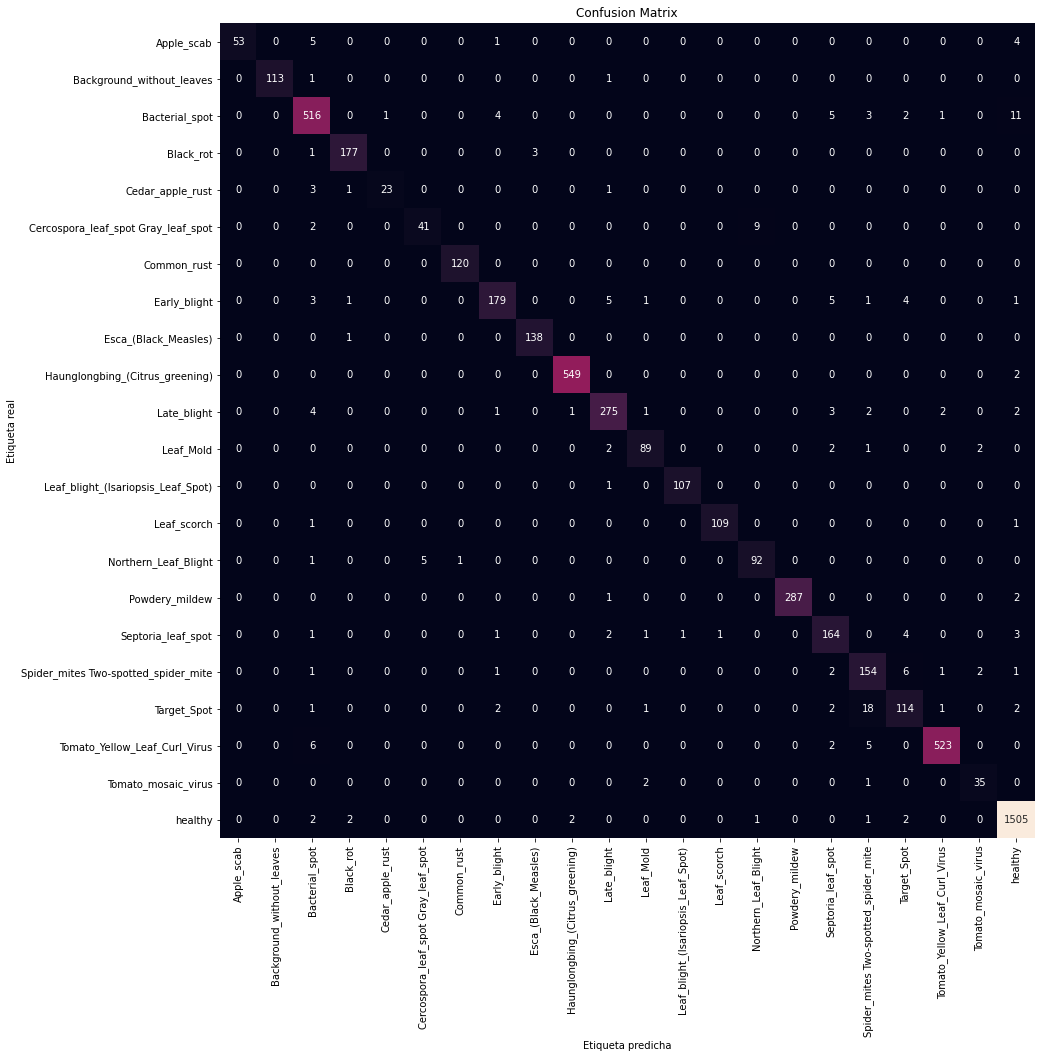

In [68]:
print('Confusion Matrix')
cm = confusion_matrix(df_test.health, df_test.healt_pred)

plt.figure(figsize=(15,15))
sns.heatmap(cm, annot=True, fmt='.0f', square=True,
             xticklabels=tick_labels_h, yticklabels=tick_labels_h,
             cbar=False)
plt.ylabel('Etiqueta real')
plt.xlabel('Etiqueta predicha')
plt.title('Confusion Matrix')
plt.show()

Confusion Matrix


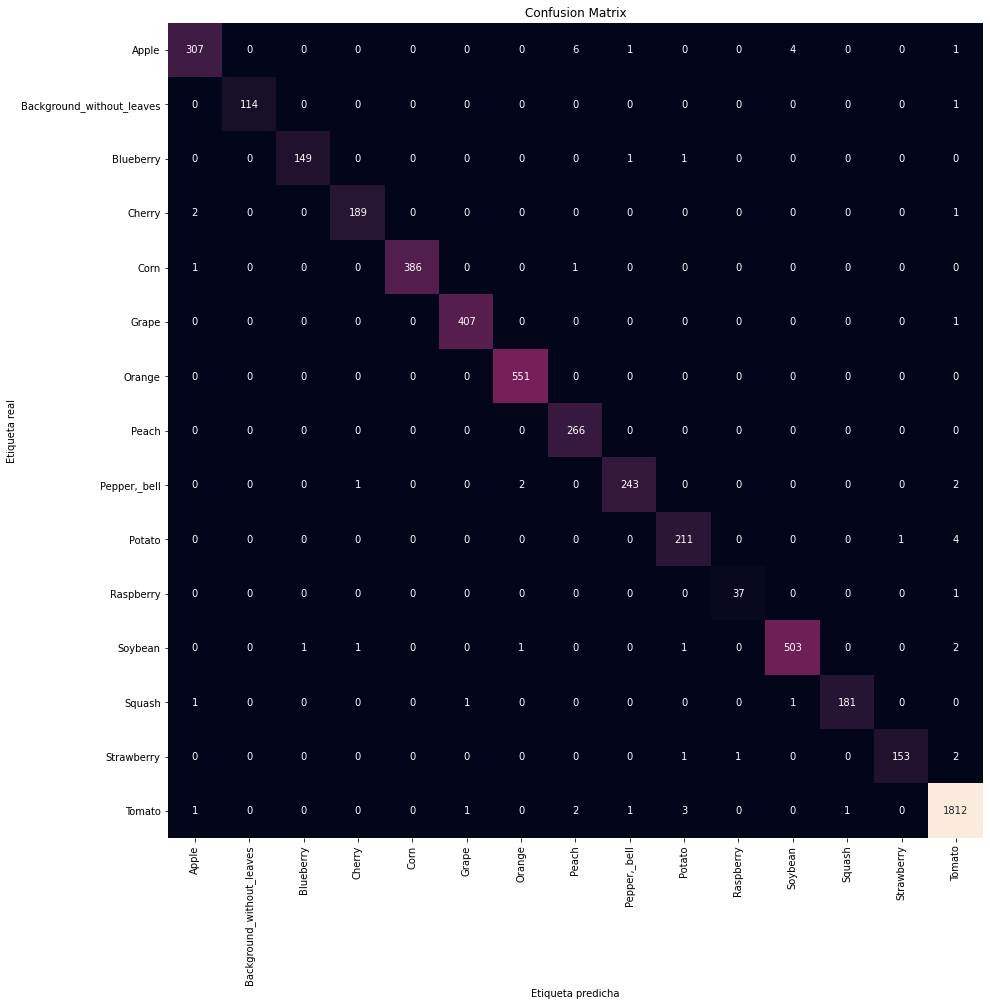

In [74]:
print('Confusion Matrix')
cm = confusion_matrix(df_test.type, df_test.type_pred)

plt.figure(figsize=(15,15))
sns.heatmap(cm, annot=True, fmt='.0f', square=True,
             xticklabels=tick_labels_t, yticklabels=tick_labels_t,
             cbar=False)
plt.ylabel('Etiqueta real')
plt.xlabel('Etiqueta predicha')
plt.title('Confusion Matrix')
plt.show()

Confusion Matrix


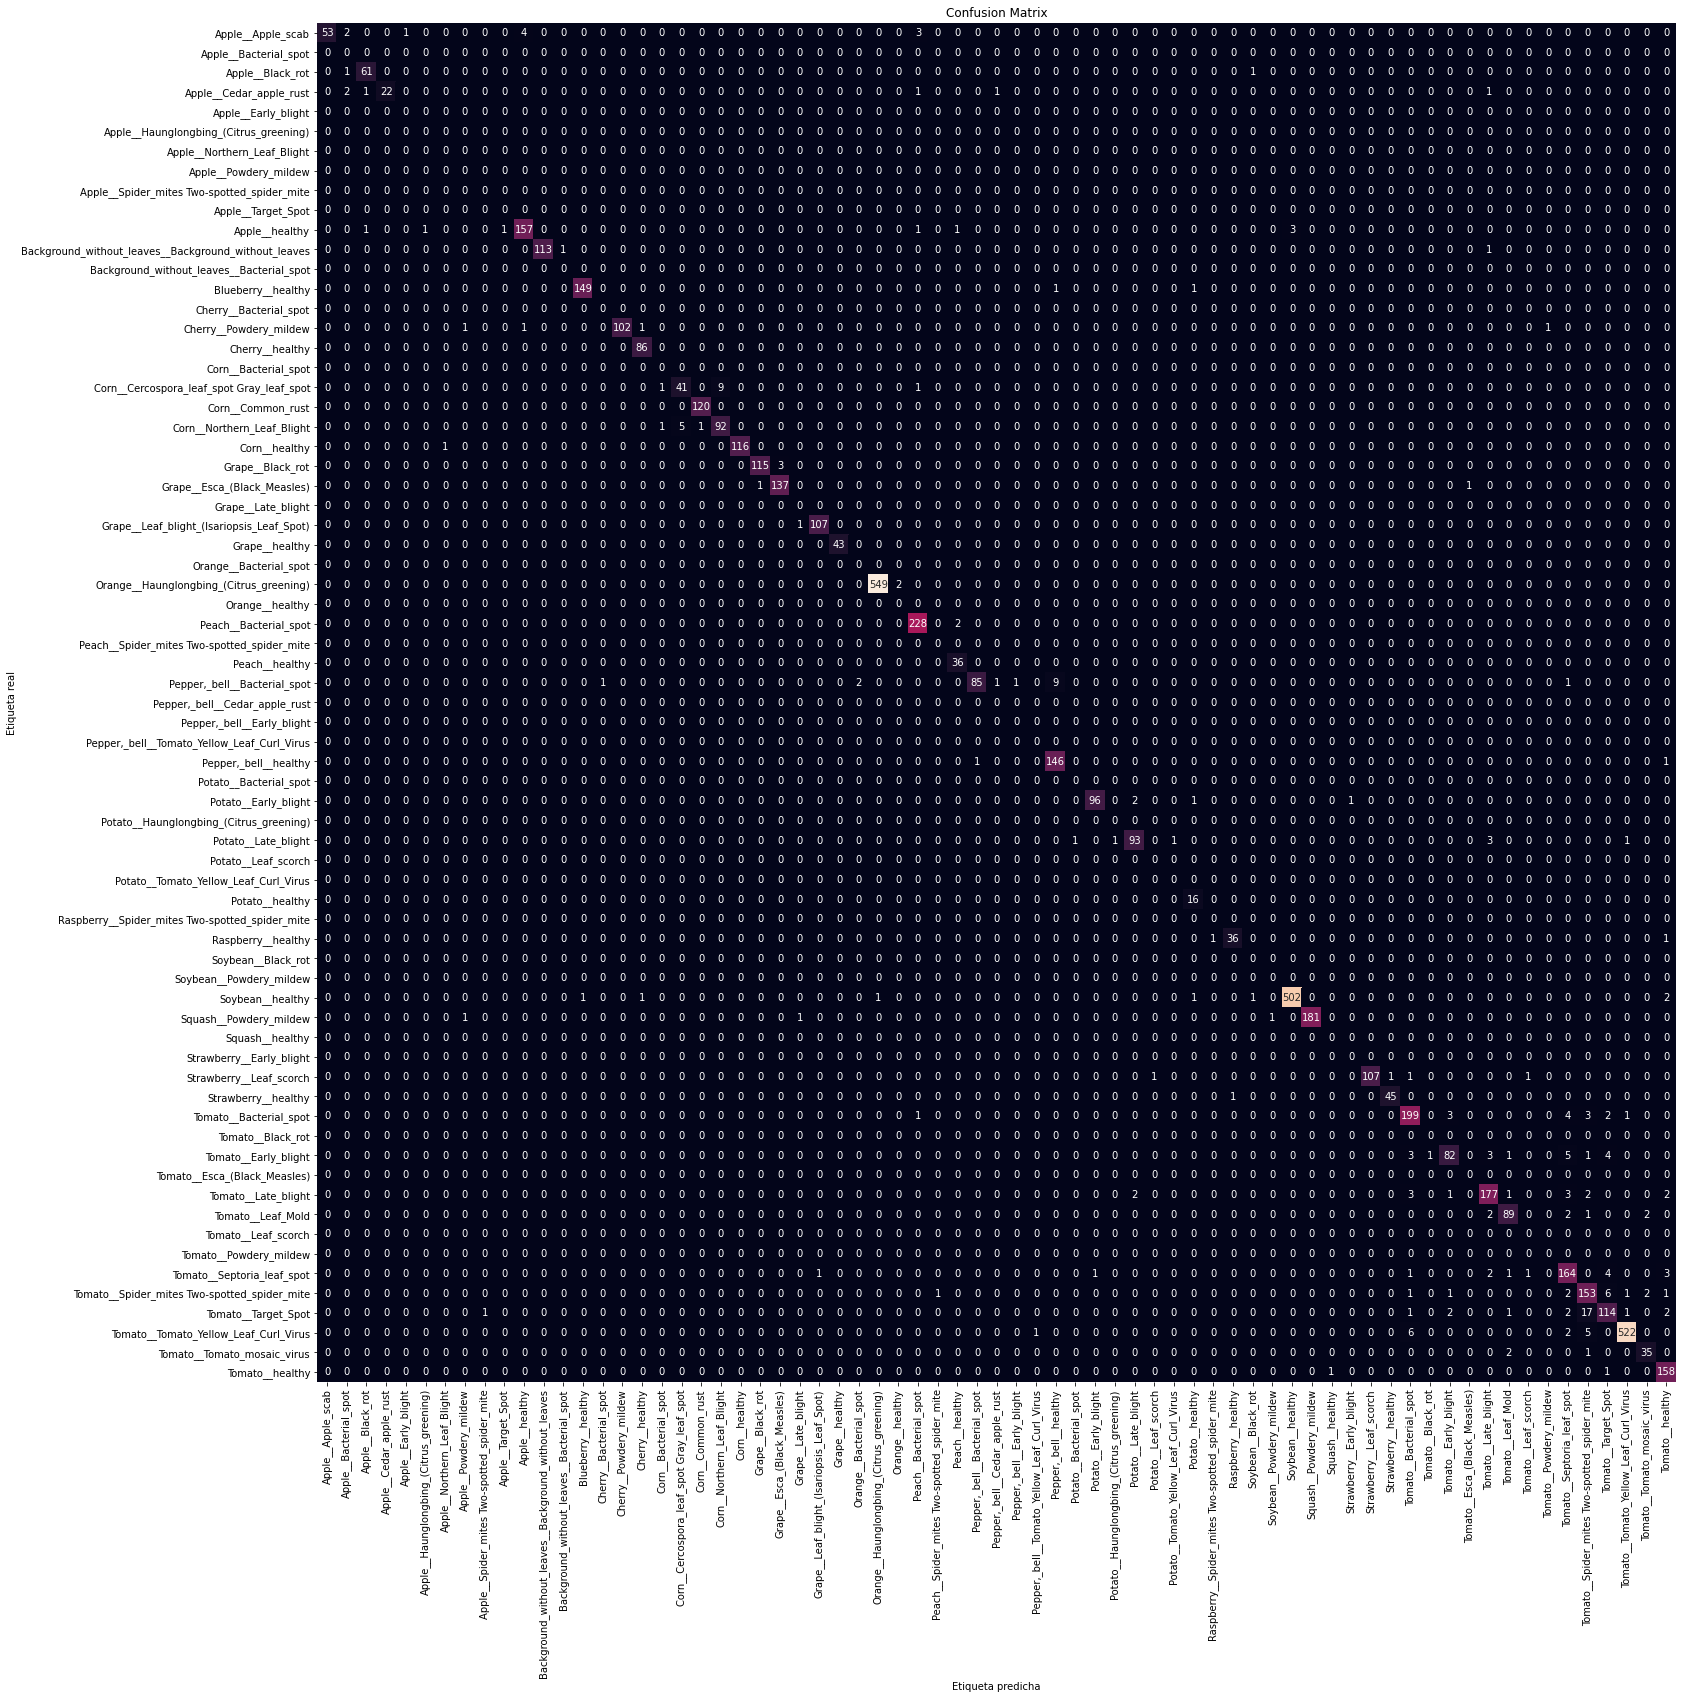

In [89]:
print('Confusion Matrix')
cm = confusion_matrix(df_test.concat_real, df_test.concat_pred)

lbl_concat_preds = np.sort(df_test.concat_pred.unique())

plt.figure(figsize=(25,25))
sns.heatmap(cm, annot=True, fmt='.0f', square=True,
             xticklabels=lbl_concat_preds, yticklabels=lbl_concat_preds,
             cbar=False)
plt.ylabel('Etiqueta real')
plt.xlabel('Etiqueta predicha')
plt.title('Confusion Matrix')
plt.show()

In [92]:
df_test.concat_pred.value_counts().tail(30)

Apple__Bacterial_spot                              5
Grape__Late_blight                                 2
Soybean__Black_rot                                 2
Orange__Bacterial_spot                             2
Orange__healthy                                    2
Tomato__Leaf_scorch                                2
Corn__Bacterial_spot                               2
Apple__Powdery_mildew                              2
Pepper,_bell__Cedar_apple_rust                     2
Apple__Early_blight                                1
Pepper,_bell__Tomato_Yellow_Leaf_Curl_Virus        1
Pepper,_bell__Early_blight                         1
Peach__Spider_mites Two-spotted_spider_mite        1
Soybean__Powdery_mildew                            1
Potato__Haunglongbing_(Citrus_greening)            1
Potato__Tomato_Yellow_Leaf_Curl_Virus              1
Apple__Haunglongbing_(Citrus_greening)             1
Tomato__Esca_(Black_Measles)                       1
Raspberry__Spider_mites Two-spotted_spider_mit

In [103]:
# Classification report
print('\nClassification Report:\n')
print(classification_report(df_test.concat_real.to_numpy().flatten(), df_test.concat_pred.to_numpy().flatten(), target_names=lbl_concat_preds, digits = 2))


Classification Report:

                                                      precision    recall  f1-score   support

                                   Apple__Apple_scab       1.00      0.84      0.91        63
                               Apple__Bacterial_spot       0.00      0.00      0.00         0
                                    Apple__Black_rot       0.97      0.97      0.97        63
                             Apple__Cedar_apple_rust       1.00      0.79      0.88        28
                                 Apple__Early_blight       0.00      0.00      0.00         0
              Apple__Haunglongbing_(Citrus_greening)       0.00      0.00      0.00         0
                         Apple__Northern_Leaf_Blight       0.00      0.00      0.00         0
                               Apple__Powdery_mildew       0.00      0.00      0.00         0
         Apple__Spider_mites Two-spotted_spider_mite       0.00      0.00      0.00         0
                                  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
